# Phising Email Sentiment Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from transformers import AutoTokenizer

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from tensorflow.keras.layers import Dense, Bidirectional, Embedding, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Functions

In [2]:
def check_for_nulls_dupes(df):
  print(f"Amount of Null Values: {df.isna().sum()}")
  print(f"Amount of Dupe Values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 6))
  plt.title("Target Class Breakdown")
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.show()
  
  plt.figure(figsize=(10, 6))
  plt.title("Target Class Breakdown")
  sns.countplot(x=target)
  plt.xlabel("Target Classes")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def remove_stop(words):
  word_tokens = " ".join(word_tokenize(words))
  filtered_tokens = re.sub(r'[^a-zA-Z\s]', "", word_tokens).split(" ")
  filtered_sentence = [w.lower().strip() for w in filtered_tokens if not w.lower().strip() in ENGLISH_STOP_WORDS]
  return " ".join(filtered_sentence).strip()

def grouped_insights(df, cols, x, metric_name):
  
  for col in cols:
    plt.figure(figsize=(10, 6))
    grouped_df = df.groupby(x)[col].sum().reset_index() if metric_name == "sum" else df.groupby(x)[col].mean().reset_index()
    sns.barplot(data=grouped_df, x=x, y =col, hue=col)
    plt.xlabel(x)
    plt.ylabel(metric_name)
    plt.title(f"{x} grouped by: {col} {metric_name}")
    plt.xticks(rotation=45)
  plt.show()

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/archive/phishing_email.csv", nrows=30000)
df

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0
...,...,...
29995,message sent feel would beneficial included i...,1
29996,summary names days dear linguists december 15 ...,0
29997,link correction 10 million sweepstakes downloa...,1
29998,job announcement taiwan university content len...,0


# Check for Nulls and Dupes

In [4]:
check_for_nulls_dupes(df)

Amount of Null Values: text_combined    0
label            0
dtype: int64
Amount of Dupe Values: 395


In [5]:
df.drop_duplicates(inplace=True)

# Check For Class Imbalance

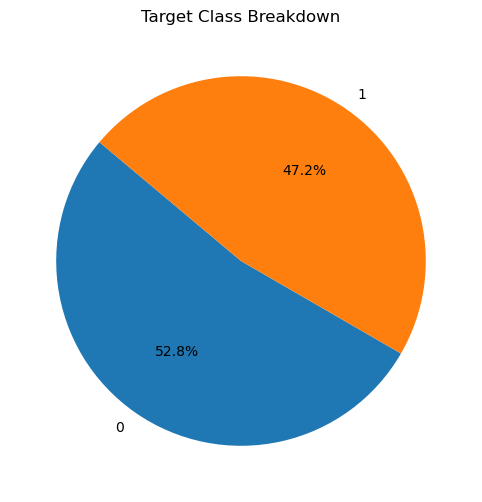

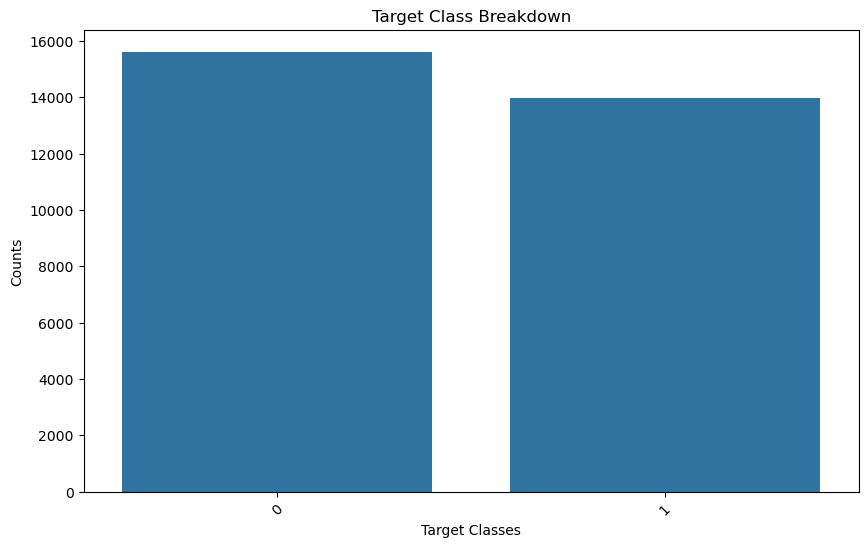

In [6]:
check_class_imbalance(df["label"])

# Balanced Class means our model can generalize more accurately on unseen data.

# Data Visuals

In [7]:
df["len_review"] = df["text_combined"].apply(lambda review: len(review))
df["word_count"] = df["text_combined"].apply(lambda review: len(review.split(" ")))

In [8]:
df.describe()

,label,len_review,word_count
count,29605.000000,29605.000000,29605.000000
mean,0.472353,1057.610573,159.142071
std,0.499243,2953.280608,429.715347
min,0.000000,1.000000,2.000000
25%,0.000000,243.000000,38.000000
50%,0.000000,501.000000,79.000000
75%,1.000000,1100.000000,170.000000
max,1.000000,160318.000000,23359.000000


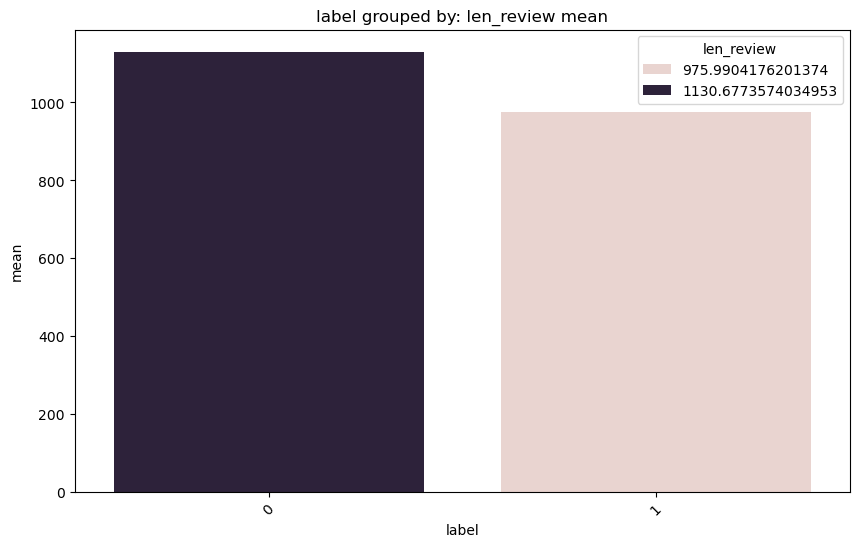

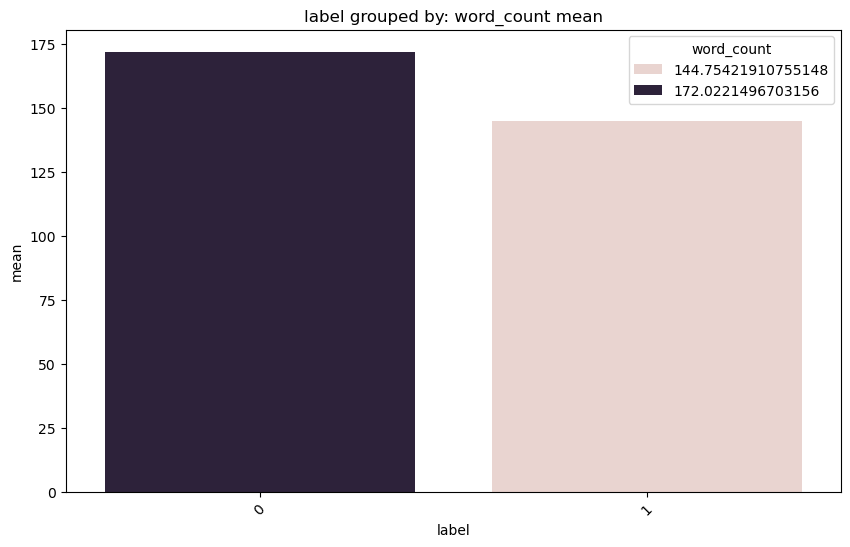

In [9]:
grouped_insights(df, ["len_review", "word_count"], "label", "mean")

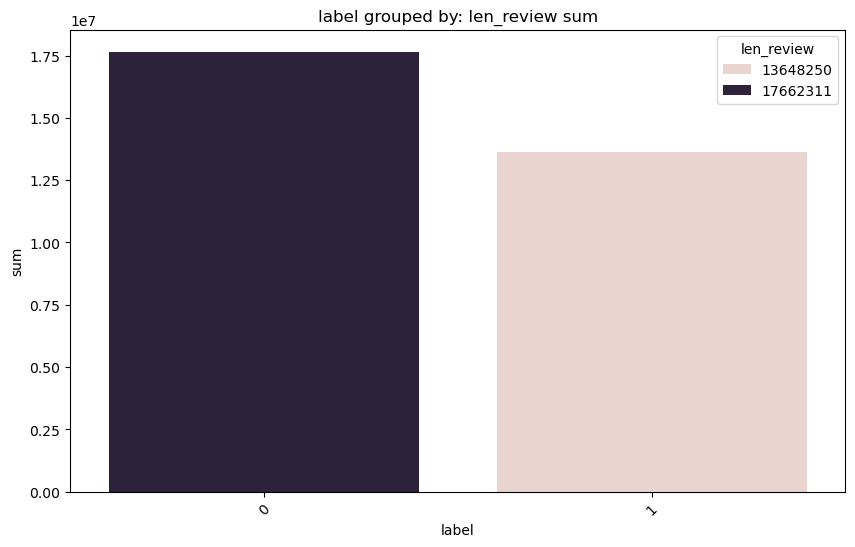

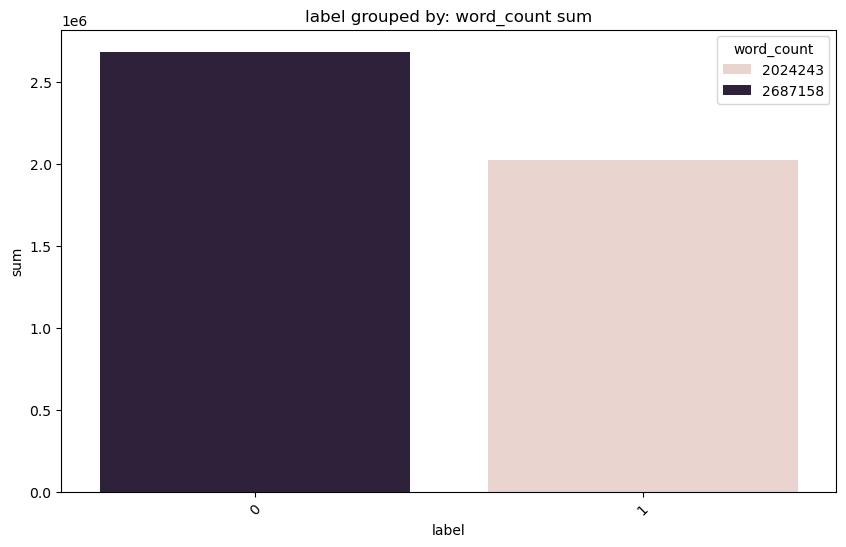

In [10]:
grouped_insights(df, ["len_review", "word_count"], "label", "sum")

# Data Preprocessing

In [11]:
df["text_combined"] = df["text_combined"].apply(remove_stop)

In [12]:
df = df[df["text_combined"] != ""]

# Bert Model

In [13]:
model ="distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

# Separate Feature Variables

In [14]:
X, y = df["text_combined"], df["label"]

In [17]:
seq = [sequence for sequence in X]
model_inputs = tokenizer(seq, padding=True, max_length=512, return_tensors="tf")

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2692: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [18]:
dataset = tf.data.Dataset.from_tensor_slices((model_inputs["input_ids"], y))

In [19]:
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [20]:
len_dataset = len(dataset)

In [21]:
train = dataset.take(int(len_dataset*.7))
test = dataset.skip(int(len_dataset*.7)).take(int(len_dataset*.2))
val = dataset.skip(int(len_dataset*.9)).take(int(len_dataset*.1))

In [22]:
early_stopping = EarlyStopping(
  monitor="val_loss",
  patience=10, 
  min_delta=0.01,
  verbose=0,
  mode="min",
  restore_best_weights=True
)